## Load Libs.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Simple Start

In [ ]:
xs = np.array([[4,5,6,7],
               [1,2,3,4],  
               [3,4,5,6], 
               [2,3,4,5],
               [5,6,7,8],
               [0,1,2,3]], dtype=float)
ys = np.array([[8,9],
               [5,6],
               [7,8],
               [6,7],
               [9,10],
               [4,5]], dtype=float)

# Train the model
tf.random.set_seed(1234)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=4, input_shape=[4], activation="relu"),
                                    tf.keras.layers.Dense(units=2)])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500, verbose=False)

print(model.predict(np.array([[13, 14, 15, 16]])).round(2))

[[16.48 18.47]]


## Larger Dataset

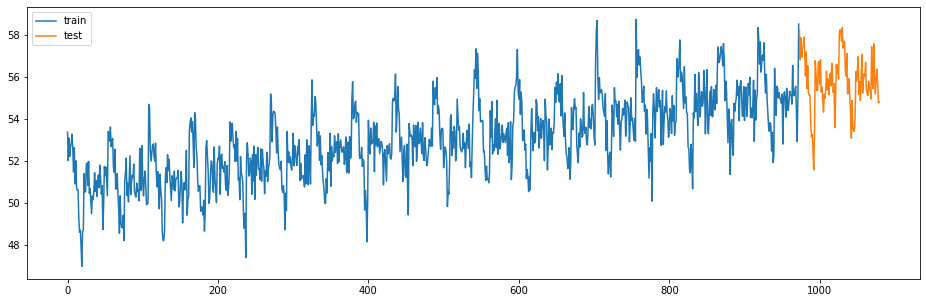

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=3, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


n_tr = 54*18 + 1
n_tst = 54*20 
start_point = 50
slope = 0.005
per = 54
noise_level = 0.75


ser_train = np.array([i for i in range(0,n_tr)])
ser_test = np.array([i for i in range(n_tr,n_tst)])

ser_train = (start_point + ser_train*slope + seasonality(ser_train, period=per) + noise(ser_train, noise_level, seed=52))
ser_test = (start_point + ser_test*slope + seasonality(ser_test, period=per) + noise(ser_test, noise_level, seed=52))

plt.figure(figsize=(16,5))
plt.plot(range(len(ser_train)), ser_train, label='train')
plt.plot(range(len(ser_train), len(ser_train)+len(ser_test)), ser_test, label='test')
plt.legend();

In [ ]:
def windowed_dataset(series, window_size, forecast_horizon, batch_size=None, n_shuffles=None):
  # convert np.array into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
  # shuffle data
  if n_shuffles:
    dataset = dataset.shuffle(n_shuffles)
  dataset = dataset.map(lambda window: (window[:-forecast_horizon], window[-forecast_horizon:]))
  if batch_size:
    dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
window_size = 27
forecast_horizon = 4


train = windowed_dataset(ser_train,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = 50)
test = windowed_dataset(ser_test,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = None)

xtr,ytr = [],[]
for x,y in train:
  xtr.append(list(x.numpy()))
  ytr.append(list(y.numpy()))

xtst,ytst = [],[]
for x, y in test:
  xtst.append(list(x.numpy()))
  ytst.append(list(y.numpy()))

xtr = np.array(xtr)
ytr = np.array(ytr)
xtst = np.array(xtst)
ytst = np.array(ytst)

print("xtr: ", xtr.shape)
print("ytr: ", ytr.shape)
print("xtst: ", xtst.shape)
print("ytst: ", ytst.shape)

xtr:  (943, 27)
ytr:  (943, 4)
xtst:  (77, 27)
ytst:  (77, 4)


In [ ]:
# Train the model
class myCallback(tf.keras.callbacks.Callback):  
  def __init__(self, threshold):
    self.threshold = threshold

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('loss') <= self.threshold):
      print("\nCancelling training!")
      self.model.stop_training = True

callbacks = myCallback(threshold=0.005)



tf.random.set_seed(5252)
model = tf.keras.models.Sequential([tf.keras.layers.Dense(units=64, input_shape=[window_size], activation="relu"),
                                    tf.keras.layers.Dense(units=64, activation="relu"),
                                    tf.keras.layers.Dense(units=32, activation="relu"),
                                    tf.keras.layers.Dense(units=forecast_horizon)])

model.compile(loss="mse", 
              optimizer='adam')

model.fit(xtr, ytr, 
          epochs=500, callbacks=callbacks, 
          verbose=0)

predictions = model.predict(xtst).round(2)

In [ ]:
# model performance
error = ytst - predictions
bayes_error = ytst-ytr.mean(axis=0)


print('** MSE **')
print("bayes mse: ",(bayes_error**2).mean(axis=0).round(4))
print('mse:       ', np.mean(error**2,axis=0).round(4),'\n')

print('** MAE **')
print("bayes mae: ",abs(bayes_error).mean(axis=0).round(4))
print('mae:       ', np.mean(abs(error),axis=0).round(4))

** MSE **
bayes mse:  [8.9725 8.9634 8.7992 8.7275]
mse:        [1.0996 0.9895 1.0115 1.2522] 

** MAE **
bayes mae:  [2.7732 2.7716 2.7418 2.727 ]
mae:        [0.8499 0.7952 0.8112 0.9163]


## RNN

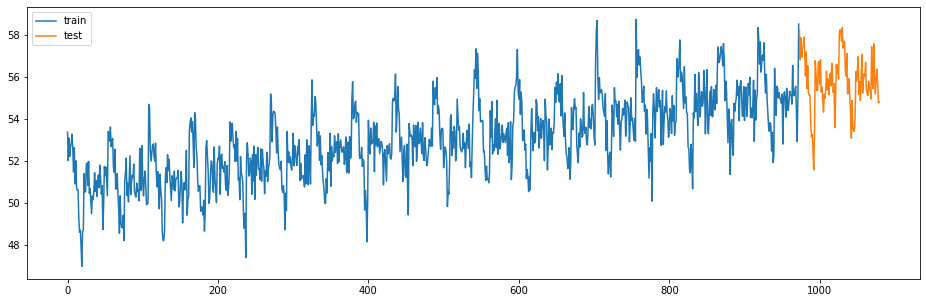

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=3, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


n_tr = 54*18 + 1
n_tst = 54*20 
start_point = 50
slope = 0.005
per = 54
noise_level = 0.75


ser_train = np.array([i for i in range(0,n_tr)])
ser_test = np.array([i for i in range(n_tr,n_tst)])

ser_train = (start_point + ser_train*slope + seasonality(ser_train, period=per) + noise(ser_train, noise_level, seed=52))
ser_test = (start_point + ser_test*slope + seasonality(ser_test, period=per) + noise(ser_test, noise_level, seed=52))

plt.figure(figsize=(16,5))
plt.plot(range(len(ser_train)), ser_train, label='train')
plt.plot(range(len(ser_train), len(ser_train)+len(ser_test)), ser_test, label='test')
plt.legend();

In [ ]:
def windowed_dataset(series, window_size, forecast_horizon, batch_size=None, n_shuffles=None):
  # convert np.array into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
  # shuffle data
  if n_shuffles:
    dataset = dataset.shuffle(n_shuffles)
  dataset = dataset.map(lambda window: (window[:-forecast_horizon], window[-forecast_horizon:]))
  if batch_size:
    dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



window_size = 27
forecast_horizon = 4


train = windowed_dataset(ser_train,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = 50)
test = windowed_dataset(ser_test,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = None)

xtr,ytr = [],[]
for x,y in train:
  xtr.append(list(x.numpy()))
  ytr.append(list(y.numpy()))

xtst,ytst = [],[]
for x, y in test:
  xtst.append(list(x.numpy()))
  ytst.append(list(y.numpy()))

xtr = np.array(xtr)
ytr = np.array(ytr)
xtst = np.array(xtst)
ytst = np.array(ytst)

print("xtr: ", xtr.shape)
print("ytr: ", ytr.shape)
print("xtst: ", xtst.shape)
print("ytst: ", ytst.shape)

xtr:  (943, 27)
ytr:  (943, 4)
xtst:  (77, 27)
ytst:  (77, 4)


** MSE **
bayes mse:  [8.9725 8.9634 8.7992 8.7275]
mse:        [0.9804 1.0849 1.3311 1.5168] 

** MAE **
bayes mae:  [2.7732 2.7716 2.7418 2.727 ]
mae:        [0.773  0.8145 0.8793 0.9497]


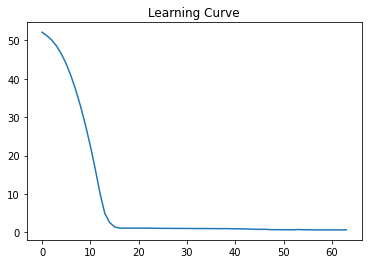

In [ ]:
# Train the model
tf.random.set_seed(5252)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.SimpleRNN(18, return_sequences=False),
  tf.keras.layers.Dense(6),
  tf.keras.layers.Dense(forecast_horizon)
])

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
history = model.fit(xtr, ytr, 
                    epochs=500, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.005,patience=5), 
                    verbose=0)

predictions = model.predict(xtst).round(2)


# model performance
error = ytst - predictions
bayes_error = ytst-ytr.mean(axis=0)

print('** MSE **')
print("bayes mse: ",(bayes_error**2).mean(axis=0).round(4))
print('mse:       ', np.mean(error**2,axis=0).round(4),'\n')

print('** MAE **')
print("bayes mae: ",abs(bayes_error).mean(axis=0).round(4))
print('mae:       ', np.mean(abs(error),axis=0).round(4))

plt.plot(history.history["loss"])
plt.title('Learning Curve');

## LSTM

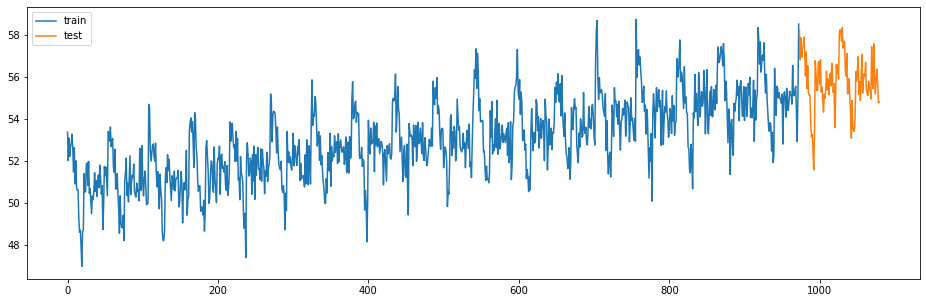

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=3, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


n_tr = 54*18 + 1
n_tst = 54*20 
start_point = 50
slope = 0.005
per = 54
noise_level = 0.75


ser_train = np.array([i for i in range(0,n_tr)])
ser_test = np.array([i for i in range(n_tr,n_tst)])

ser_train = (start_point + ser_train*slope + seasonality(ser_train, period=per) + noise(ser_train, noise_level, seed=52))
ser_test = (start_point + ser_test*slope + seasonality(ser_test, period=per) + noise(ser_test, noise_level, seed=52))

plt.figure(figsize=(16,5))
plt.plot(range(len(ser_train)), ser_train, label='train')
plt.plot(range(len(ser_train), len(ser_train)+len(ser_test)), ser_test, label='test')
plt.legend();

In [ ]:
def windowed_dataset(series, window_size, forecast_horizon, batch_size=None, n_shuffles=None):
  # convert np.array into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
  # shuffle data
  if n_shuffles:
    dataset = dataset.shuffle(n_shuffles)
  dataset = dataset.map(lambda window: (window[:-forecast_horizon], window[-forecast_horizon:]))
  if batch_size:
    dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



window_size = 27
forecast_horizon = 4


train = windowed_dataset(ser_train,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = 50)
test = windowed_dataset(ser_test,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = None)

xtr,ytr = [],[]
for x,y in train:
  xtr.append(list(x.numpy()))
  ytr.append(list(y.numpy()))

xtst,ytst = [],[]
for x, y in test:
  xtst.append(list(x.numpy()))
  ytst.append(list(y.numpy()))

xtr = np.array(xtr)
ytr = np.array(ytr)
xtst = np.array(xtst)
ytst = np.array(ytst)

print("xtr: ", xtr.shape)
print("ytr: ", ytr.shape)
print("xtst: ", xtst.shape)
print("ytst: ", ytst.shape)

xtr:  (943, 27)
ytr:  (943, 4)
xtst:  (77, 27)
ytst:  (77, 4)


** MSE **
bayes mse:  [8.9725 8.9634 8.7992 8.7275]
mse:        [1.4047 1.7916 1.4455 1.5834] 

** MAE **
bayes mae:  [2.7732 2.7716 2.7418 2.727 ]
mae:        [0.9367 1.0486 0.9286 0.957 ]


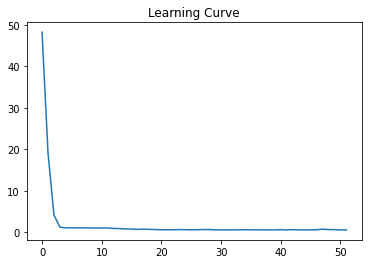

In [ ]:
# Train the model
tf.random.set_seed(5252)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    #tf.keras.layers.Conv1D(filters=64, kernel_size=14,
    #                      activation="relu",
    #                      input_shape=[None, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(40, return_sequences=False)),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(forecast_horizon)
])

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2))
history = model.fit(xtr, ytr, 
                    epochs=500, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=0.001,patience=10), 
                    verbose=0)

predictions = model.predict(xtst).round(2)


# model performance
error = ytst - predictions
bayes_error = ytst-ytr.mean(axis=0)

print('** MSE **')
print("bayes mse: ",(bayes_error**2).mean(axis=0).round(4))
print('mse:       ', np.mean(error**2,axis=0).round(4),'\n')

print('** MAE **')
print("bayes mae: ",abs(bayes_error).mean(axis=0).round(4))
print('mae:       ', np.mean(abs(error),axis=0).round(4))

plt.plot(history.history["loss"])
plt.title('Learning Curve');

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, 80)               13440     
 l)                                                              
                                                                 
 dense (Dense)               (None, 10)                810       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 14,294
Trainable params: 14,294
Non-trainable params: 0
_________________________________________________________________


## Multi Output (Functional API)

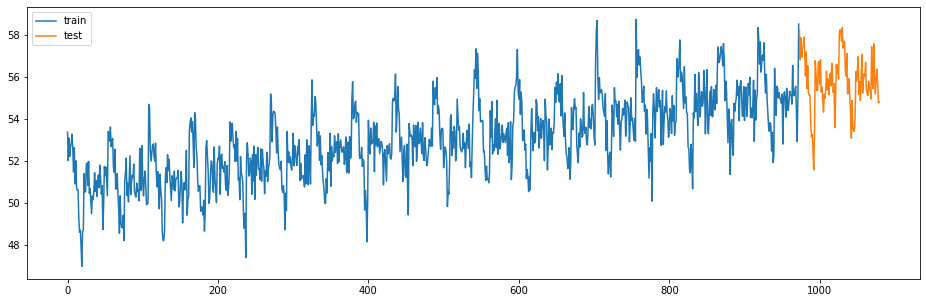

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=3, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


n_tr = 54*18 + 1
n_tst = 54*20 
start_point = 50
slope = 0.005
per = 54
noise_level = 0.75


ser_train = np.array([i for i in range(0,n_tr)])
ser_test = np.array([i for i in range(n_tr,n_tst)])

ser_train = (start_point + ser_train*slope + seasonality(ser_train, period=per) + noise(ser_train, noise_level, seed=52))
ser_test = (start_point + ser_test*slope + seasonality(ser_test, period=per) + noise(ser_test, noise_level, seed=52))

plt.figure(figsize=(16,5))
plt.plot(range(len(ser_train)), ser_train, label='train')
plt.plot(range(len(ser_train), len(ser_train)+len(ser_test)), ser_test, label='test')
plt.legend();

In [ ]:
def windowed_dataset(series, window_size, forecast_horizon, batch_size=None, n_shuffles=None):
  # convert np.array into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
  # shuffle data
  if n_shuffles:
    dataset = dataset.shuffle(n_shuffles)
  dataset = dataset.map(lambda window: (window[:-forecast_horizon], window[-forecast_horizon:]))
  if batch_size:
    dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



window_size = 54
forecast_horizon = 4


train = windowed_dataset(ser_train,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = 50)
test = windowed_dataset(ser_test,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = None)

xtr,ytr = [],[]
for x,y in train:
  xtr.append(list(x.numpy()))
  ytr.append(list(y.numpy()))

xtst,ytst = [],[]
for x, y in test:
  xtst.append(list(x.numpy()))
  ytst.append(list(y.numpy()))

xtr = np.array(xtr)
ytr = np.array(ytr)
xtst = np.array(xtst)
ytst = np.array(ytst)

print("xtr: ", xtr.shape)
print("ytr: ", ytr.shape)
print("xtst: ", xtst.shape)
print("ytst: ", ytst.shape)

xtr:  (916, 54)
ytr:  (916, 4)
xtst:  (50, 54)
ytst:  (50, 4)


In [ ]:
def multi_target_output(data):
  y1,y2,y3,y4 = [],[],[],[]
  for y in data:
    y1.append(y[0])
    y2.append(y[1])
    y3.append(y[2])
    y4.append(y[3])
  return (np.array(y1),np.array(y2),np.array(y3),np.array(y4))


y_tr = multi_target_output(ytr)
y_tst = multi_target_output(ytst)

print("y_tr: ",np.shape(y_tr))
print("y_tst: ",np.shape(y_tst))

y_tr:  (4, 916)
y_tst:  (4, 50)


In [ ]:
def build_model_with_functional(input_shape, output_shape, show=False):

    # set random state
    tf.random.set_seed(5252)
    
    # Input layers
    input_layer = tf.keras.Input(shape=(input_shape,))
    first_dense = tf.keras.layers.Dense(64, activation=tf.nn.relu)(input_layer)
    second_dense = tf.keras.layers.Dense(64, activation=tf.nn.relu)(first_dense)
    third_dense = tf.keras.layers.Dense(32, activation=tf.nn.relu)(second_dense)
    
    # single output
    #output_layer = tf.keras.layers.Dense(output_shape)(first_dense)
    #func_model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

    # y1 forecast
    y1_output = tf.keras.layers.Dense(units=1, name='y1_output')(first_dense)
    # y2 forecast
    y2_output = tf.keras.layers.Dense(units=1, name='y2_output')(first_dense)
    # y3 forecast
    y3_output = tf.keras.layers.Dense(units=1, name='y3_output')(first_dense)
    # y4 forecast
    y4_output = tf.keras.layers.Dense(units=1, name='y4_output')(first_dense)

    # define model
    func_model = tf.keras.models.Model(inputs=input_layer, outputs=[y1_output,
                                                                    y2_output,
                                                                    y3_output,
                                                                    y4_output])
    
    if show:
      print(func_model.summary())

    
    return func_model

In [ ]:
# loss object
from tensorflow.keras.losses import Loss

class HuberLoss(Loss):
  
    # initialize instance attributes
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold

    # compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

** MSE **
bayes mse:  [9.2351 8.8445 8.3848 7.9874]
mse:        [2.5993 1.6962 1.7148 3.5926] 

** MAE **
bayes mae:  [2.7695 2.7192 2.6502 2.5864]
mae:        [1.2576 1.0229 1.0625 1.4773]


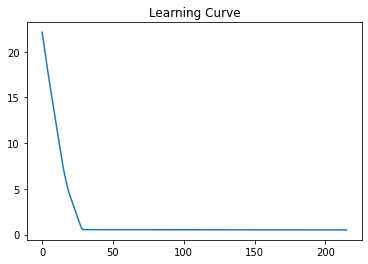

In [ ]:
model = build_model_with_functional(window_size, forecast_horizon)

# configure, train, and evaluate the model
huber_threshold = 0.1
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
              loss={'y1_output': HuberLoss(huber_threshold), 
                    'y2_output': HuberLoss(huber_threshold), 
                    'y3_output': HuberLoss(huber_threshold), 
                    'y4_output': HuberLoss(huber_threshold)})

history = model.fit(xtr, y_tr, 
                    epochs=500, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=1e-5,patience=10), 
                    verbose=0)

y_preds = model.predict(xtst)
predictions = np.column_stack((y_preds[0],
                               y_preds[1],
                               y_preds[2],
                               y_preds[3]))
predictions = predictions.round(2)

# model performance
error = ytst - predictions
bayes_error = ytst-ytr.mean(axis=0)

print('** MSE **')
print("bayes mse: ",(bayes_error**2).mean(axis=0).round(4))
print('mse:       ', np.mean(error**2,axis=0).round(4),'\n')

print('** MAE **')
print("bayes mae: ",abs(bayes_error).mean(axis=0).round(4))
print('mae:       ', np.mean(abs(error),axis=0).round(4))

plt.plot(history.history["loss"])
plt.title('Learning Curve');

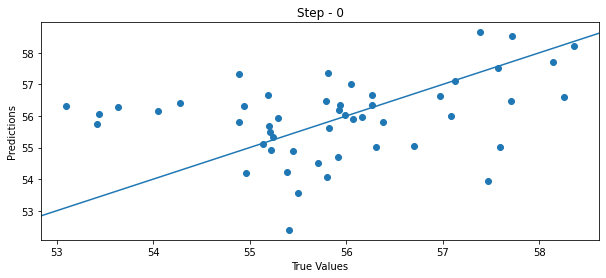

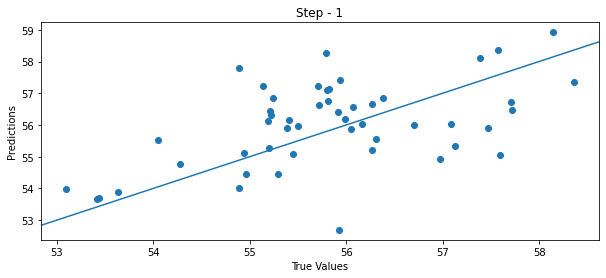

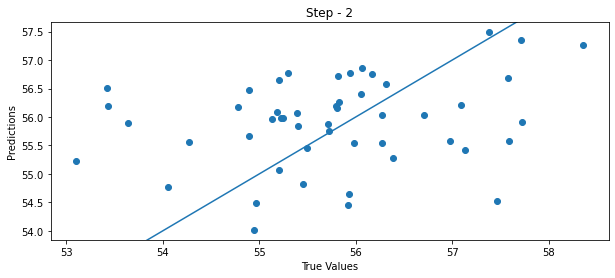

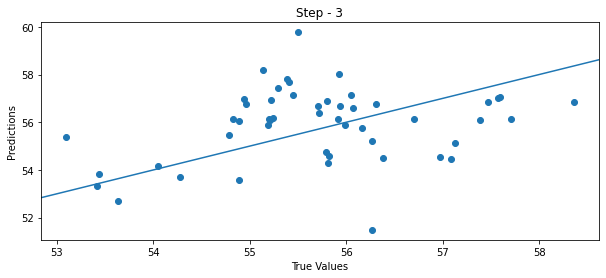

In [ ]:
for i in range(4):
  t = 'Step - ' + str(i)

  plt.figure(figsize=(10,4))
  plt.scatter(y_tst[i], y_preds[i])
  plt.title(t)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 500], [-100, 500])
  plt.show()

## Deeper Model

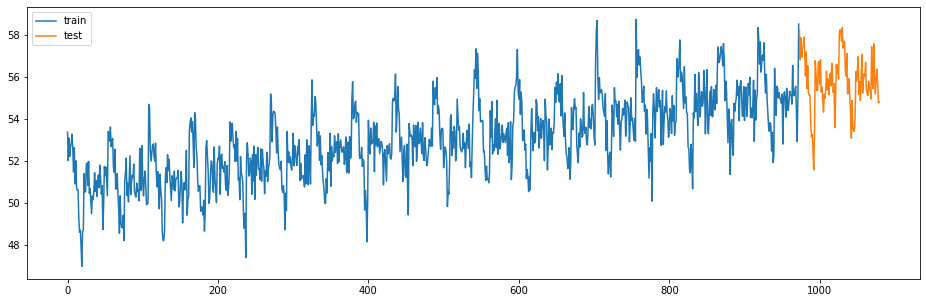

In [ ]:
def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=3, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


n_tr = 54*18 + 1
n_tst = 54*20 
start_point = 50
slope = 0.005
per = 54
noise_level = 0.75


ser_train = np.array([i for i in range(0,n_tr)])
ser_test = np.array([i for i in range(n_tr,n_tst)])

ser_train = (start_point + ser_train*slope + seasonality(ser_train, period=per) + noise(ser_train, noise_level, seed=52))
ser_test = (start_point + ser_test*slope + seasonality(ser_test, period=per) + noise(ser_test, noise_level, seed=52))

plt.figure(figsize=(16,5))
plt.plot(range(len(ser_train)), ser_train, label='train')
plt.plot(range(len(ser_train), len(ser_train)+len(ser_test)), ser_test, label='test')
plt.legend();

In [ ]:
def windowed_dataset(series, window_size, forecast_horizon, batch_size=None, n_shuffles=None):
  # convert np.array into tensor
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + forecast_horizon, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + forecast_horizon))
  # shuffle data
  if n_shuffles:
    dataset = dataset.shuffle(n_shuffles)
  dataset = dataset.map(lambda window: (window[:-forecast_horizon], window[-forecast_horizon:]))
  if batch_size:
    dataset = dataset.batch(batch_size).prefetch(1)
  return dataset



window_size = 54
forecast_horizon = 4


train = windowed_dataset(ser_train,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = 50)
test = windowed_dataset(ser_test,
                        window_size = window_size, forecast_horizon = forecast_horizon,
                        batch_size = None, n_shuffles = None)

xtr,ytr = [],[]
for x,y in train:
  xtr.append(list(x.numpy()))
  ytr.append(list(y.numpy()))

xtst,ytst = [],[]
for x, y in test:
  xtst.append(list(x.numpy()))
  ytst.append(list(y.numpy()))

xtr = np.array(xtr)
ytr = np.array(ytr)
xtst = np.array(xtst)
ytst = np.array(ytst)

print("xtr: ", xtr.shape)
print("ytr: ", ytr.shape)
print("xtst: ", xtst.shape)
print("ytst: ", ytst.shape)

xtr:  (916, 54)
ytr:  (916, 4)
xtst:  (50, 54)
ytst:  (50, 4)


In [ ]:
def multi_target_output(data):
  y1,y2,y3,y4 = [],[],[],[]
  for y in data:
    y1.append(y[0])
    y2.append(y[1])
    y3.append(y[2])
    y4.append(y[3])
  return (np.array(y1),np.array(y2),np.array(y3),np.array(y4))


y_tr = multi_target_output(ytr)
y_tst = multi_target_output(ytst)

print("y_tr: ",np.shape(y_tr))
print("y_tst: ",np.shape(y_tst))

y_tr:  (4, 916)
y_tst:  (4, 50)


In [ ]:
# loss object
from tensorflow.keras.losses import Loss

class HuberLoss(Loss):
  
    # initialize instance attributes
    def __init__(self, threshold=1):
        super().__init__()
        self.threshold = threshold

    # compute loss
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) <= self.threshold
        small_error_loss = tf.square(error) / 2
        big_error_loss = self.threshold * (tf.abs(error) - (0.5 * self.threshold))
        return tf.where(is_small_error, small_error_loss, big_error_loss)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

# inherit from the Model base class
class WideAndDeepModel(Model):
    def __init__(self, units=12, filters=64, kernel_size=12, activation='relu', **kwargs):
        '''initializes the instance attributes'''
        super().__init__(**kwargs)
        self.exp_dim = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)) 
        self.conv_1d = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation=activation)
        self.batch_norm = tf.keras.layers.BatchNormalization()
        self.bi_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units, return_sequences=False))
        self.dense1 = tf.keras.layers.Dense(units, activation=activation)
        self.dense2 = tf.keras.layers.Dense(units, activation=activation)

        self.output_1 = tf.keras.layers.Dense(1)
        self.output_2 = tf.keras.layers.Dense(1)
        self.output_3 = tf.keras.layers.Dense(1)
        self.output_4 = tf.keras.layers.Dense(1)

    def call(self, inputs):
        '''defines the network architecture'''

        exp_dim = self.exp_dim(inputs)
        conv_1d = self.conv_1d(exp_dim)
        batch_norm = self.batch_norm(conv_1d)
        
        bi_lstm = self.bi_lstm(batch_norm)

        concat = tf.keras.layers.concatenate([inputs, bi_lstm])
        
        dense_1 = self.dense1(concat)
        dense_2 = self.dense2(dense_1)

        output_1 = self.output_1(dense_2)
        output_2 = self.output_1(dense_2)
        output_3 = self.output_1(dense_2)
        output_4 = self.output_1(dense_2)
        
        return output_1, output_2, output_3, output_4 

** MSE **
bayes mse:  [9.2351 8.8445 8.3848 7.9874]
mse:        [0.7546 0.7872 1.0813 0.9301] 

** MAE **
bayes mae:  [2.7695 2.7192 2.6502 2.5864]
mae:        [0.7037 0.7005 0.8434 0.7939]


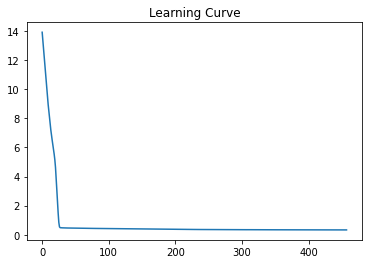

In [ ]:
# define model
model = WideAndDeepModel()


# train & predict
huber_threshold = 0.1
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-5),
              loss={'output_1': HuberLoss(huber_threshold), 
                    'output_2': HuberLoss(huber_threshold), 
                    'output_3': HuberLoss(huber_threshold), 
                    'output_4': HuberLoss(huber_threshold)})

history = model.fit(xtr, y_tr, 
                    epochs=500, 
                    callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss',min_delta=1e-5,patience=10), 
                    verbose=0)

y_preds = model.predict(xtst)
predictions = np.column_stack((y_preds[0],
                               y_preds[1],
                               y_preds[2],
                               y_preds[3]))
predictions = predictions.round(2)


# model evaluate
error = ytst - predictions
bayes_error = ytst-ytr.mean(axis=0)

print('** MSE **')
print("bayes mse: ",(bayes_error**2).mean(axis=0).round(4))
print('mse:       ', np.mean(error**2,axis=0).round(4),'\n')

print('** MAE **')
print("bayes mae: ",abs(bayes_error).mean(axis=0).round(4))
print('mae:       ', np.mean(abs(error),axis=0).round(4))

plt.plot(history.history["loss"])
plt.title('Learning Curve');

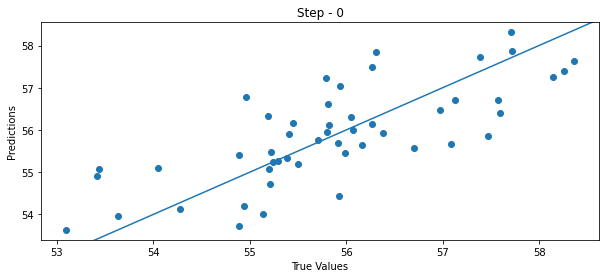

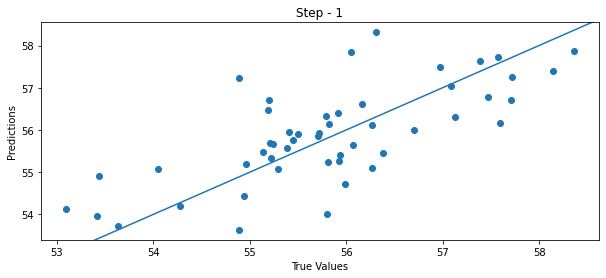

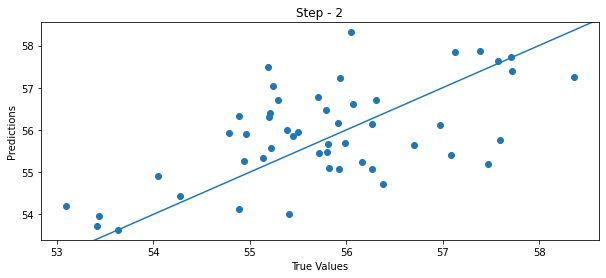

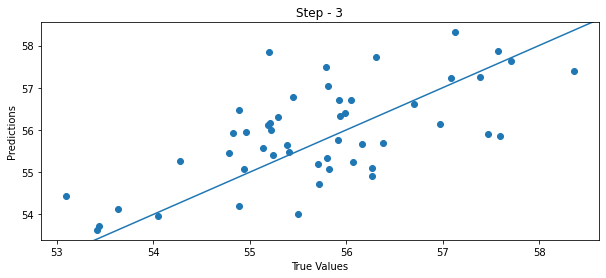

In [ ]:
# results
for i in range(4):
  t = 'Step - ' + str(i)

  plt.figure(figsize=(10,4))
  plt.scatter(y_tst[i], y_preds[i])
  plt.title(t)
  plt.xlabel('True Values')
  plt.ylabel('Predictions')
  plt.xlim(plt.xlim())
  plt.ylim(plt.ylim())
  plt.plot([-100, 500], [-100, 500])
  plt.show()